Welcome to the Constructive Course Evaluation Filter.  This software uses natural language processing to filter out unconstructive comments, leaving you with only constructive comments in an output .docx file in the "results" folder.


**Please click the folder icon at the left of the screen** to connect and open a file browser.

**Drag your qualitative course evaluations into the white space at left to upload them.  When you're ready, click "Run all" from the Runtime menu.**  Then scroll down to watch your progress below the Process Files block.

Note that while this page accepts .pdf files, .txt files, and .docx files, we have gotten the best results by copying the desired comments, opening a new Word document, and choosing "paste without formatting" by right-clicking or from the Edit menu.

**When the page finishes (typically after 5-10 minutes), click the folder icon at left, then click again to refresh.  Your detoxified course evaluation comments will be available to view or download as .docx files in the *results* folder.**  Now savor the joy of iterative improvement with a bit less vitriol!  

Please note that the model also removes a small number of constructive comments as it does its work but is calibrated to leave behind enough for us to take useful feedback without having to read through any nasty ones.

Please contact John at jgoeltz (at) csumb (dot) edu with feedback or questions.

# Install/Import

In [7]:
# install
!pip install textract
!pip install python-docx
!pip install tensorflow
!pip install ktrain
!pip install googledrivedownloader

# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ktrain
from ktrain import text
import re
import os
import textract
import docx
from google_drive_downloader import GoogleDriveDownloader as gdd

  Using cached six-1.12.0-py2.py3-none-any.whl (10 kB)
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires six~=1.15.0, but you have six 1.12.0 which is incompatible.


  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textract 1.6.3 requires six==1.12.0, but you have six 1.15.0 which is incompatible.


  Attempting uninstall: six
    Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0


In [8]:
# define paths and global variables

PATH_MODEL = './model'
LABELS = ['constructive', 'toxic']
MODEL_NAME = 'bert-base-uncased'
MAXLEN = 150

!mkdir model
!mkdir results

A subdirectory or file model already exists.
A subdirectory or file results already exists.


In [9]:
gdd.download_file_from_google_drive(file_id='1IdaLnT4sNyXZ5M0jXXS76lPOh7FQ59Be',
                                    dest_path='model/config.json')
gdd.download_file_from_google_drive(file_id='1oFvCOk6y93u1sOdmmF7lF_Ep23P_3Xce',
                                    dest_path='model/tf_model.h5')
gdd.download_file_from_google_drive(file_id='1GsQAszVoiJG3qs-JBLsXeMj9IW7NPl_e',
                                    dest_path='model/tf_model.preproc')

In [10]:
# load model
model = ktrain.load_predictor('./model').model

# Get predictor object
t = text.Transformer(MODEL_NAME, maxlen=MAXLEN)
t.preprocess_train_called = True
predictor = ktrain.get_predictor(model, preproc=t)

# Functions

In [11]:
def split_colon(x):
    if re.search(": ", x):
        return str(x).split(': ')[1]
    else:
        return x

In [12]:
def import_pdf(pdf_path):
    text = textract.process(pdf_path)

    # split by new line
    temp_word_list = re.split("\\\\n", str(text))
    
    # convert list to dataframe 
    temp_df = pd.DataFrame(temp_word_list)
    return temp_df

def import_txt(txt_path):
    temp_df = pd.read_csv(txt_path, delimiter="\n")

    # convert to strings, remove text such as "Assignments:"
    temp_df = temp_df.applymap(lambda x: str(x))
    temp_df = temp_df.applymap(lambda x: split_colon(x))

    # rename column
    temp_df = temp_df.rename(columns=({list(temp_df.columns)[0]:'comments'}))
    return temp_df

def import_word(word_path):
    # import and split by \n using python-docx
    doc = docx.Document(word_path)
    paras = [p.text for p in doc.paragraphs if p.text]
    
    # make dataframe of strings; clean up text; rename column
    temp_df = pd.DataFrame(paras)
    temp_df = temp_df.applymap(lambda x: str(x))
    temp_df = temp_df.applymap(lambda x: split_colon(x))
    temp_df = temp_df.rename(columns=({list(temp_df.columns)[0]:'comments'}))
    return temp_df

def process_dataframe(temp_df, filename):
    # convert to array (needed for ktrain predictor input)
    eval_comments = np.asarray(temp_df.comments)
    
    # use model to classify comments
    eval_tox = predictor.predict(eval_comments)

    # concatenate results with comments; label and plot
    eval_results_df = pd.concat([pd.DataFrame(eval_comments).rename(
        columns={0:'comments'}), pd.DataFrame(eval_tox).rename(
            columns={0:'constructive', 1:'toxic'})], axis=1)
    eval_results_df.loc[eval_results_df['constructive'] >= 
                        eval_results_df['toxic'], 'class'] = 'constructive' 
    eval_results_df.loc[eval_results_df['constructive'] < 
                        eval_results_df['toxic'], 'class'] = 'toxic'
    print('Constructive and Toxic comments found for ' + filename)
    plt.bar(['constructive', 'toxic'], eval_results_df['class'].value_counts())
    plt.show()

    # keep only constructive, non-toxic comments
    constructive_results = eval_results_df.where(
        eval_results_df['class'] == 'constructive').dropna()['comments']
 
    # convert from series to df so .shape helps set up table properly
    constructive_results = pd.DataFrame(constructive_results)

    # open an new document
    doc = docx.Document()

    # add a table; extra row is for the header
    t = doc.add_table(constructive_results.shape[0]+1, 
                      constructive_results.shape[1])

    # add the header row
    for j in range(constructive_results.shape[-1]):t.cell(0,j).text = \
    constructive_results.columns[j]

    # add the rest of the data frame
    # may want to redo as nested list comprehension, but it works
    for i in range(constructive_results.shape[0]):
        for j in range(constructive_results.shape[-1]):
            t.cell(i+1,j).text = str(constructive_results.values[i,j])

    # save the doc
    doc.save('./results/' + filename.split('.')[0] + '.docx')


# Process files

Constructive and Toxic comments found for short_course_eval_sample.docx


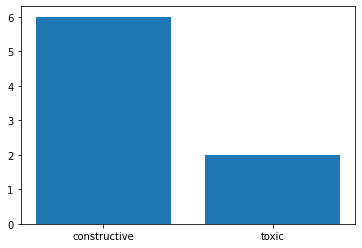

In [13]:
#@title ## Plots showing the relative numbers of constructive and toxic comments for each document you uploaded will appear below.  Your output files will be in the "results" folder in the file browser at left.

for filename in os.listdir(os.getcwd()):
    # process any pdf files
    if re.search('pdf$', filename):
        try:
            temp_df = import_pdf(filename)
            process_dataframe(temp_df, filename)
        except Exception as e:
            print('An exception was raised for ' + filename + ':\n')
            print(e)

    # process any txt files
    if re.search('txt$', filename):
        try:
            temp_df = import_txt(filename)
            process_dataframe(temp_df, filename)
        except Exception as e:
            print('An exception was raised for ' + filename + ':\n')
            print(e)

    # process any Word .docx files
    if re.search('docx$', filename):
        try:
            temp_df = import_word(filename)
            process_dataframe(temp_df, filename)
        except Exception as e:
            print('An exception was raised for ' + filename + ':\n')
            print(e)
